In [58]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from uszipcode import SearchEngine
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import time
#install package for spatial feature engineering
!pip install uszipcode

In [ ]:
import os
os.chdir('data')

In [4]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
#look at the data
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [ ]:
by_zone = train.apply(pd.Series.value_counts).reset_index()

# Load SF data
!wget --quiet https://cocl.us/sanfran_geojson -O sf_neighborhoods.json
sf_zones = r'sf_neighborhoods.json'

SF_COORDINATES = (37.76, -122.45)
 

# Create an empty map zoomed in on San Francisco
sf_crime_map = folium.Map(location=SF_COORDINATES, zoom_start=12)


sf_crime_map.choropleth(
    geo_data=sf_zones,
    data=by_zone,
    columns=['index', 'PdDistrict'],
    key_on='feature.properties.DISTRICT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='San Fransisco Crime by Neighborhood'
)

sf_crime_map

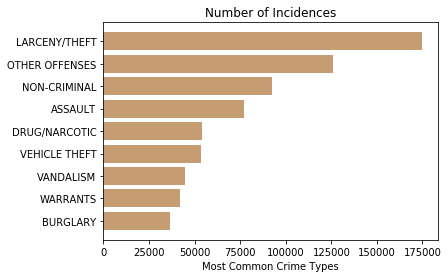

In [6]:
# Look at the 10 most common crimes
most_common_cat = train['Category'].value_counts()[0:9].sort_values()
most_common_cat.values


categs = most_common_cat.index
y_pos = np.arange(len(categs))
counts = most_common_cat.values

plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, categs)
plt.xlabel('Most Common Crime Types')
plt.title('Number of Incidences')

plt.show()

In [12]:
print('{} outliers, {}% of the total training set'.format(
    len(train[train['Y']>40]), round((len(train[train['Y']>40])*100)/len(train),2)))

67 outliers, 0.01% of the total training set


In [49]:
# Impute zipcde for outlier points (#categories remains the same)
train.loc[train['Y']>=90,'zipcode'] = 94103
test.loc[test['Y']>=90,'zipcode'] = 94103
train_zips = pd.concat([train_zips, train[train.Y>=90]], ignore_index = True).drop('Unnamed: 0',axis=1)
test_zips = pd.concat([test_zips, test[test.Y>=90]], ignore_index = True).drop('Unnamed: 0',axis=1)

Feature Engineering

In [37]:
#First check columns that exist in both datasets
print([val if val in test.columns.values else '' for val in train.columns.values])

['Unnamed: 0', 'Address', '', 'Dates', 'DayOfWeek', '', 'PdDistrict', '', 'X', 'Y', 'zipcode']


In [38]:
#Can we do something with District? No, this will be categorical
print(train['PdDistrict'].unique())
#Perhaps population density? Pull from uszipcode but by coordinates
#NOTE: false simple zipcode means 450MB download but so many more columns! :) 
#EDIT: false simple zipcode takes too long to lookup. Get full list of zips first, then use it.
search = SearchEngine(simple_zipcode=True)

['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']


In [39]:
#add zipcode and population density based on coordinates. X is longitude, Y is latitude
def zip_lookup(lat,lon):
    #only return closest zipcode
    try:
        for zipcode in search.by_coordinates(lat,lon,radius=5,returns=1):
            zp = zipcode.to_dict()
        return zp['zipcode']
    except:
        return None

In [40]:
#pull in features for a single zipcode
def zip_dict(zp):
    search = SearchEngine(simple_zipcode=False)
    d = search.by_zipcode(str(zp)).to_dict()
    d['zipcode'] = zp
    return d

In [41]:
#take as input the full training dataset, including census columns
#in which values are nested dictionaries
def clean_data(df):
    #initialize drop column list
    cols_to_drop = []
    df['zipcode'] = df['zipcode'].astype(int)
    for i,dtype in enumerate(df.dtypes):
        if dtype == 'object':
            cols_to_drop.append(i)
            #for each category in a list of dictionaries, add a column for that category
            for j,dic in enumerate(df.iloc[0,i][0]['values']):
                #subset the nested dictionary, appending all values (both null and real)
                df[dic['x']] = [val[0]['values'][j]['y'] if val != None 
                                else None for val in df.iloc[:,i].values]
    #drop non-numerical columns
    df.drop(df.columns[cols_to_drop],axis=1,inplace=True)
    return df

In [42]:
#add features here 
feats = ['zipcode','population_by_race','population_by_age',\
                'families_vs_singles','median_household_income','housing_occupancy','employment_status',\
                'educational_attainment_for_population_25_and_over','source_of_earnings',\
                'school_enrollment_age_3_to_17']

def zip_engineer(df, feats):
    df['zipcode'] = df['zipcode'].astype(int)
    #lookup stats by each zipcode
    zip_df = pd.DataFrame({'zipcode':df['zipcode'].dropna().unique()})
    zip_df = pd.DataFrame.from_records(zip_df.loc[:,'zipcode'].apply(lambda x: zip_dict(x)))
    #select columns to keep
    zip_df = zip_df[feats]
    zip_df_clean = clean_data(zip_df)
    #merging zip reference with original df on zipcode
    merged = pd.merge(df,zip_df_clean,how='left',on='zipcode')
    return merged

In [43]:
def time_engineer(data):
    # Turn strings onto timestamp objects
    data.Dates = pd.to_datetime(data.Dates)

    # Extract years, months, times of the day, and weeks of year
    data['Year'] = data['Dates'].dt.year
    data['Month'] = data['Dates'].dt.month
    data['Day'] = data['Dates'].dt.day
    data['Hour'] = data['Dates'].dt.hour
    data['WeekOfYear'] = data['Dates'].dt.weekofyear

    # Add a dummy for public holidays
    cal = calendar()
    holidays = cal.holidays(start=data['Dates'].min(), end=data['Dates'].max())
    data['Holiday'] = data['Dates'].dt.date.astype('datetime64').isin(holidays)

    # Add times of a day
    data['Night'] = np.where((data['Hour']< 6), 1, 0)
    data['Morning'] = np.where((data['Hour']>=6) & (data['Hour']<12), 1, 0)
    data['Afternoon'] = np.where((data['Hour']>= 12) & (data['Hour']<18), 1, 0)
    data['Evening'] = np.where((data['Hour']>= 18) & (data['Hour']<24), 1, 0)
    data['BusinessHour'] = np.where((data['Hour']>= 8) & (data['Hour']<18), 1, 0)

    # Add seasons
    data['Spring'] = np.where((data['Month']>=3) & (data['Month']<6), 1, 0)
    data['Summer'] = np.where((data['Month']>=6) & (data['Month']<9), 1, 0)
    data['Autumn'] = np.where((data['Month']>=9) & (data['Month']<12), 1, 0)
    data['Winter'] = np.where((data['Month']<=2) | (data['Month']==12), 1, 0)

    # Encode weekdays
    data_dummies = pd.get_dummies(data['DayOfWeek'])
    data = pd.concat([data, data_dummies], axis=1)

    # Create a dummy for weekends
    data['Weekend'] = np.where((data['DayOfWeek']=='Saturday') & (data['DayOfWeek']=='Sunday'), 1, 0)

    # Encode districts
    data_dummies = pd.get_dummies(data['PdDistrict'])
    data = pd.concat([data, data_dummies], axis=1)
    data = data.drop(columns=['PdDistrict'])
    return data

In [52]:
train_eng = zip_engineer(train, feats)
train_eng = time_engineer(train_eng)
train_eng.to_csv('train_eng_full.csv')

In [53]:
test_eng = zip_engineer(test,feats)
test_eng = time_engineer(test_eng)
test_eng.to_csv('test_eng_full.csv')

Modeling

In [18]:
data = pd.read_csv('train_eng_full.csv')
test = pd.read_csv('test_eng_full.csv')

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

In [36]:
# Encode the labels
cat_le = LabelEncoder()
cat_le.fit(data['Category'].unique())
data['Category'] = cat_le.transform(data['Category'])
y = data['Category']
# Save our mapping
decoder = dict(zip(cat_le.transform(cat_le.classes_), cat_le.classes_))

In [37]:
# Select only numeric features
features = data.select_dtypes(exclude=['object'])
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)

In [68]:
# Try out different models
models = [LogisticRegression(solver='lbfgs',multi_class='multinomial'), RandomForestClassifier(), \
          KNeighborsClassifier()]

def run_model(model, X_train, y_train, X_test, y_test, final=False):
    start = time.time()
    #fit the model to the training data
    model.fit(X_train, y_train)
    #predict the probability for each class (category) 
    y_preds = model.predict_proba(X_test)
    runtime = time.time() - start
    if final==True:
        return y_preds
    return {'log loss':(log_loss(y_test, y_preds, labels=np.unique(y_train))),
            'runtime (s)':runtime}
    
results = [run_model(model, X_train, y_train, X_test, y_test) for model in models]

/Users/connormitchell/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/connormitchell/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [69]:
results_df = pd.DataFrame.from_dict(results)
results_df['model'] = ['logistic regression', 'random forest', 'KNN']
results_df

,log loss,runtime (s),model
0,2.645550,202.962555,logistic regression
1,3.478473,41.240819,random forest
2,18.241259,42.061112,KNN


In [ ]:
submission_preds = run_model(models[results.index(max(results))], features, y, test, None, 
                             final=True)
submission_preds.to_csv('SFCrime_kaggle_submission.csv')